# Language Models Use Trigonometry to Do Addition

## **Objective**
The goal of this study is to investigate how transformers utilize **hidden state representations** to perform fundamental mathematical operations such as **addition**. Specifically, the study explores:
1. **How numbers are represented within the residual stream** across multiple layers.
2. **How attention and MLP mechanisms interact** to modify and propagate numerical representations.
3. **What underlying algorithms transformers learn** to perform arithmetic operations.

 <img src="fig1.jpg" width="600"/>


## Problem Definition

### **Background**
Autoregressive transformers are widely used in language models to process sequential data by predicting the next token in a given sequence. These models take as input a sequence of tokens $x_0, ..., x_n$ and generate probability distributions over possible next tokens $x_{n+1}$, enabling tasks such as text generation, mathematical reasoning, and code completion.

### **Formal Definition**
Given a sequence of tokens $x_0, x_1, ..., x_n$, an autoregressive transformer processes each token through a **residual stream** comprising multiple layers of computation. Each layer consists of two primary components: **multi-head self-attention** and **multi-layer perceptrons (MLPs)**. The hidden state representation at layer $l$ for token $i$ is computed as:

$$
h^l_i = h^{l-1}_i + a^l_i + m^l_i
$$

where:
- $h^l_i$ represents the hidden state at layer $l$ for token $i$,
- $a^l_i$ is the output of the **attention mechanism**, computed as:

  $$
  a^l_i = \text{attn}^l(h^{l-1}_1, h^{l-1}_2, ..., h^{l-1}_i)
  $$

- $m^l_i$ is the output of the **MLP component**, computed as:

  $$
  m^l_i = \text{MLP}^l(a^l_i + h^{l-1}_i)
  $$




## Load the model


In [1]:
import torch
import numpy as np
from tqdm import tqdm, trange
from nnsight import LanguageModel
import matplotlib.pyplot as plt
import pandas as pd
import os
from huggingface_hub import login
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import pickle
from sklearn.exceptions import ConvergenceWarning
import warnings
import itertools
import json


/home/eltsai/anaconda3/envs/llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load model# Set the token as an environment variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
full_model_name = 'EleutherAI/gpt-j-6B'#'meta-llama/Llama-3.1-8B'# #'EleutherAI/pythia-6.9b'## # #'google/gemma-2-9b'#'
MODEL_NAME = full_model_name.split('/')[-1]
model = LanguageModel(full_model_name, device_map=device, torch_dtype=torch.bfloat16, dispatch=True)
remote = False
NLAYERS = model.config.num_hidden_layers

device

Some weights of the model checkpoint at EleutherAI/gpt-j-6B were not used when initializing GPTJForCausalLM: ['transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.12.attn.bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.13.attn.bias', 'transformer.h.13.attn.masked_bias', 'transformer.h.14.attn.bias', 'transformer.h.14.attn.masked_bias', 'transformer.h.15.attn.bias', 'transformer.h.15.attn.masked_bias', 'transformer.h.16.attn.bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.17.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.19.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.2.attn.bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.20.attn.bi

device(type='cuda', index=0)

In [15]:
NLAYERS

28

In [16]:
model

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): Embedding(50400, 4096)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-27): 28 x GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (out_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): GPTJMLP(
          (fc_in): Linear(in_features=4096, out_features=16384, bias=True)
          (fc_out): Linear(in_features=16384, out_features=4096, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f)

<img src="transformers.png" alt="Transformers architecture" width="400">


## Generate addition evaluation data

In [3]:
np.random.seed(42)
def gen_math(mina = 0, maxa = 99):
    data = []
    with torch.no_grad():
        for a in tqdm(range(mina, maxa + 1)):
            for b in range(mina, maxa + 1):
                if MODEL_NAME == 'gpt-j-6B':
                    q_string = f'Output ONLY a number.\n{a}+{b}='
                elif MODEL_NAME == 'Llama-3.1-8B':
                    q_string = f'The following is a correct addition problem. \n{a}+{b}='
                    #q_string = f'The following is a correction addition problem. {a}+0='
                elif MODEL_NAME == 'pythia-6.9b':
                    q_string = f'Output ONLY a number. {a}+{b}='
                q_toks = model.tokenizer(q_string)['input_ids']
                answer = a+b
                answer_tok = model.tokenizer(f'{answer}')['input_ids']
                if MODEL_NAME == 'Llama-3.1-8B':
                    answer_tok = [answer_tok[-1]]
                #print(answer_tok)
                data.append({
                    'a': a,
                    'b': b,
                    'q_string': q_string,
                    'q_tok': q_toks,
                    'answer': answer,
                    'answer_tok': answer_tok
                })
    df = pd.DataFrame(data)
    df.to_pickle(f'data_addition/gen_math/data_addition_{mina}_{maxa}_{MODEL_NAME}.pkl')
    return df


#evaluate_math(mina = 0, maxa = 500)
gen_math(mina = 0, maxa = 99)
#data = get_math_gen()

100%|██████████| 100/100 [00:00<00:00, 140.86it/s]


,a,b,q_string,q_tok,answer,answer_tok
0,0,0,Output ONLY a number.\n0+0=,"[26410, 22224, 257, 1271, 13, 198, 15, 10, 15,...",0,[15]
1,0,1,Output ONLY a number.\n0+1=,"[26410, 22224, 257, 1271, 13, 198, 15, 10, 16,...",1,[16]
2,0,2,Output ONLY a number.\n0+2=,"[26410, 22224, 257, 1271, 13, 198, 15, 10, 17,...",2,[17]
3,0,3,Output ONLY a number.\n0+3=,"[26410, 22224, 257, 1271, 13, 198, 15, 10, 18,...",3,[18]
4,0,4,Output ONLY a number.\n0+4=,"[26410, 22224, 257, 1271, 13, 198, 15, 10, 19,...",4,[19]
...,...,...,...,...,...,...
9995,99,95,Output ONLY a number.\n99+95=,"[26410, 22224, 257, 1271, 13, 198, 2079, 10, 3...",194,[22913]
9996,99,96,Output ONLY a number.\n99+96=,"[26410, 22224, 257, 1271, 13, 198, 2079, 10, 4...",195,[22186]
9997,99,97,Output ONLY a number.\n99+97=,"[26410, 22224, 257, 1271, 13, 198, 2079, 10, 5...",196,[25272]
9998,99,98,Output ONLY a number.\n99+98=,"[26410, 22224, 257, 1271, 13, 198, 2079, 10, 4...",197,[24991]


In [4]:
def evaluate_math(mina = 0, maxa = 99, verbose = False, batch_size = 100):
    df = pd.read_pickle(f'data_addition/gen_math/data_addition_{mina}_{maxa}_{MODEL_NAME}.pkl')
    #df = df.sample(n=15, random_state=42)
    corrects = []
    with torch.no_grad():
        # Process rows in batches
        bar = tqdm(range(0, len(df), batch_size))
        for step in bar:
            batch_df = df.iloc[step:min(step + batch_size, len(df))]
            batch_toks = torch.stack([torch.tensor(x) for x in batch_df['q_tok'].values]).to(device)
            # Combine into single batch tensor
            answer_toks = torch.stack([torch.tensor(x)[0] for x in batch_df['answer_tok'].values])
            # Get model outputs for batch
            with model.trace() as tracer:
                with tracer.invoke(batch_toks) as invoker:
                    pass
                output = model.output.save()
            
            # Get predictions for batch
            logits = output.logits[:,-1].cpu()
            #print(model.tokenizer.batch_decode(output.logits[0].argmax(dim=-1)))
            model_answers = logits.argmax(dim=-1)
            correct = (model_answers == answer_toks).float()
            incorrect_mask = correct == 0
            if incorrect_mask.any() and verbose:
                print("Incorrect answers:")
                print("Expected:", model.tokenizer.batch_decode(answer_toks[incorrect_mask].unsqueeze(-1)))
                print("Got:", model.tokenizer.batch_decode(model_answers[incorrect_mask].unsqueeze(-1)))
            corrects.extend(list(correct))
            bar.set_postfix({'%': np.mean(corrects)})
            
    df['correct'] = corrects
    df.to_pickle(f'data_addition/gen_math/data_addition_correct_{mina}_{maxa}_{MODEL_NAME}.pkl')
    return np.mean(corrects)




In [5]:
evaluate_math(mina = 0, maxa = 99, verbose = False)


100%|██████████| 100/100 [00:14<00:00,  6.85it/s, %=0.806]


0.8061

In [12]:
def get_correct_df(mina = 0, maxa = 99):
    df = pd.read_pickle(f'data_addition/gen_math/data_addition_correct_{mina}_{maxa}_{MODEL_NAME}.pkl')
    return df[df['correct'] == 1]

def get_df_sample(mina = 0, maxa = 99, num_sample = 500, run = False):
    if run:
        df = get_correct_df(mina, maxa)
        df = df.sample(n=num_sample, random_state=42).reset_index(drop=True)
        # Save sampled dataframe
        save_path = f'data_addition/gen_math/data_addition_correct_sample_{mina}_{maxa}_{MODEL_NAME}.pkl'
        df.to_pickle(save_path)
    return pd.read_pickle(f'data_addition/gen_math/data_addition_correct_sample_{mina}_{maxa}_{MODEL_NAME}.pkl')

def get_output_tokens(mina = 0, maxa = 99):
    # answers range from 0, 99 * 2 
    avals, toks = [], []
    for a in range(mina, 2 * maxa + 1):
        atok = model.tokenizer(f'{a}')['input_ids']
        avals.append(a)
        toks.append(atok[0])
    return avals, toks

a, toks = get_output_tokens()
df = get_df_sample(run = True)


In [13]:
ANS_SEQPOS_DICT
df

,a,b,q_string,q_tok,answer,answer_tok,correct
0,9,51,Output ONLY a number.\n9+51=,"[26410, 22224, 257, 1271, 13, 198, 24, 10, 434...",60,[1899],tensor(1.)
1,25,39,Output ONLY a number.\n25+39=,"[26410, 22224, 257, 1271, 13, 198, 1495, 10, 2...",64,[2414],tensor(1.)
2,45,49,Output ONLY a number.\n45+49=,"[26410, 22224, 257, 1271, 13, 198, 2231, 10, 2...",94,[5824],tensor(1.)
3,56,54,Output ONLY a number.\n56+54=,"[26410, 22224, 257, 1271, 13, 198, 3980, 10, 4...",110,[11442],tensor(1.)
4,77,15,Output ONLY a number.\n77+15=,"[26410, 22224, 257, 1271, 13, 198, 3324, 10, 1...",92,[5892],tensor(1.)
...,...,...,...,...,...,...,...
495,4,4,Output ONLY a number.\n4+4=,"[26410, 22224, 257, 1271, 13, 198, 19, 10, 19,...",8,[23],tensor(1.)
496,75,15,Output ONLY a number.\n75+15=,"[26410, 22224, 257, 1271, 13, 198, 2425, 10, 1...",90,[3829],tensor(1.)
497,74,11,Output ONLY a number.\n74+11=,"[26410, 22224, 257, 1271, 13, 198, 4524, 10, 1...",85,[5332],tensor(1.)
498,62,5,Output ONLY a number.\n62+5=,"[26410, 22224, 257, 1271, 13, 198, 5237, 10, 2...",67,[3134],tensor(1.)


In [39]:



target = 'b'
mina = 0
maxa = 99
batch_size = 80
sample = False

ANS_SEQPOS = ANS_SEQPOS_DICT[target]

a = torch.tensor(df['a'].values)
b = torch.tensor(df['b'].values)
a_b = a+b
hss = []
with torch.no_grad():
    for step in tqdm(range(0, len(df), batch_size)):
        batch_df = df.iloc[step:min(step + batch_size, len(df))]
        tokens = torch.stack([torch.tensor(x) for x in batch_df['q_tok'].values]).to(device)
        layer_hss = []
        with model.trace(validate=False,remote=remote) as tracer:
            with tracer.invoke(tokens, scan=False):
                for layer in range(NLAYERS):
                    if MODEL_NAME == 'Llama-3.1-8B':
                        hs = model.model.layers[layer].input
                    elif MODEL_NAME == 'gpt-j-6B':
                        hs = model.transformer.h[layer].inputs[1]['hidden_states']
                    elif MODEL_NAME == 'pythia-6.9b':
                        hs = model.gpt_neox.layers[layer].input
                    layer_hss.append(hs[:,ANS_SEQPOS].save())
        layer_hss = [layer_hs.detach().cpu() for layer_hs in layer_hss] # gets hs on top of ans_token
        layer_hss = torch.stack(layer_hss, dim=1) # stack along new layer dimension
        hss.append(layer_hss)
hss = torch.cat(hss, dim=0) # concat along batch dimension
# Save nums and hss to file with descriptive name
# Use _FULL in filename if using complete dataset
suffix = '_FULL' if not sample else ''
save_path = f'data/helix_hss/{target}_helix_data_{mina}_{maxa}{suffix}_{MODEL_NAME}.pt'
# Create directory if it doesn't exist
os.makedirs('data/helix_hss', exist_ok=True)
# Save tensors
torch.save({
    'a': a,
    'b':b,
    'a+b':a_b,
    'hidden_states': hss
}, save_path)




# run_hs('a', sample = False)
#run_hs('a', sample = True)
#get_nums_hss('a', sample = True)

100%|██████████| 7/7 [00:00<00:00,  9.85it/s]


In [29]:
def get_nums_hss(target, mina = 0,maxa = 99, sample = False):
    suffix = '_FULL' if not sample else ''
    save_path = f'data/helix_hss/{target}_helix_data_{mina}_{maxa}{suffix}_{MODEL_NAME}.pt'
    obj = torch.load(save_path, weights_only=True)
    a,b,a_b, hss = obj['a'], obj['b'], obj['a+b'], obj['hidden_states']
    return a,b,a_b, hss

a,b,a_b, hss = get_nums_hss('a')

In [32]:
NLAYERS

28

In [37]:
hss.shape

torch.Size([500, 28, 4096])

## PCA Functions

In [40]:
def run_pca(target, mina = 0, maxa = 99, NUM_PCA = 100):
    _,_,_, hss = get_nums_hss(target, mina, maxa) # we want the full thing for a pca
    pca_components = {}
    for layer in tqdm(range(hss.shape[1])):
        hs = hss[:,layer]
        # Convert to numpy for sklearn
        hs_numpy = hs.float().numpy()
        # Fit PCA without dimensionality reduction
        pca = PCA(n_components=NUM_PCA)# None
        pca.fit(hs_numpy)
        # Store components for this layer
        pca_components[layer] = {
            'explained_variance_ratio': pca.explained_variance_ratio_,
            'components': pca.components_,
            'singular_values': pca.singular_values_,
            'mean': pca.mean_
        }
    # Save PCA components to file with descriptive name
    save_path = f'data/helix_pca/{target}_pca_data_{mina}_{maxa}_{MODEL_NAME}.pt'
    # Create directory if it doesn't exist
    os.makedirs('data/helix_pca', exist_ok=True)
    # Save dictionary
    torch.save(pca_components, save_path)
    return pca_components

def get_pca(target, layer, mina = 0, maxa = 99):
    save_path = f'data/helix_pca/{target}_pca_data_{mina}_{maxa}_{MODEL_NAME}.pt'
    pca_data = torch.load(save_path, weights_only = False)[layer]
    return pca_data

run_pca('b')
pca_data = get_pca('b', 18)

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [00:17<00:00,  1.64it/s]


## Investigating Numerical Structure

### Linear Structure

Generated hidden states for 100


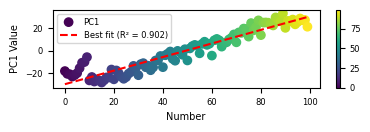

In [45]:
from sklearn.preprocessing import StandardScaler
COL_WIDTH = 3.25
TWO_COL_WIDTH = 6.75

plt.rcParams.update({
    'font.size': 10,               # Default text size
    'axes.titlesize': 7,          # Title size for axes
    'axes.labelsize': 7,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 10,        # Overall figure title size
})
def get_nums_hidden_states(mina = 0,maxa = 99):
    nums = np.linspace(mina, maxa, maxa-mina+1)
    tokens = torch.tensor(model.tokenizer([f'{int(num)}' for num in nums])['input_ids'])
    activations = []
    with torch.no_grad():
        with model.trace(validate=False,remote=remote) as tracer:
            with tracer.invoke(tokens, scan=False):
                for layer in range(NLAYERS):
                    activations.append(model.transformer.h[layer].inputs[1]['hidden_states'][:,-1].save())
    act = torch.stack(activations).detach().cpu()
    print(f'Generated hidden states for {len(nums)}')
    return nums, act



def get_pc1(mina, maxa, skip0, layer):
    nums, hss = get_nums_hidden_states(mina, maxa)
    hs = hss[layer].cpu().float().numpy()
    # Perform PCA
    
    # Scale the data
    scaler = StandardScaler()
    hs_scaled = scaler.fit_transform(hs)
    
    # Get first principal component
    pca = PCA(n_components=1)
    pc1_vals = pca.fit_transform(hs_scaled).flatten()
    
    # Print variance explained by PC1
    
    # Create plot
    plt.figure(figsize=(1.25*COL_WIDTH, 1.25*0.35*COL_WIDTH))
    
    # Create scatter plot colored by number value
    scatter = plt.scatter(nums, pc1_vals, c=nums, cmap='viridis', label = 'PC1')
    
    # Calculate line of best fit
    slope, intercept = np.polyfit(nums, pc1_vals, 1)
    line_x = nums
    line_y = slope * line_x + intercept
    
    # Calculate R^2
    r_squared = np.corrcoef(nums, pc1_vals)[0,1]**2
    
    # Plot line of best fit
    plt.plot(line_x, line_y, 'r--', label=f'Best fit (R² = {r_squared:.3f})')
    
    # Add colorbar
    plt.colorbar(scatter)
    
    plt.xlabel('Number')
    plt.ylabel('PC1 Value')
    
    plt.legend()
    plt.tight_layout()
    # Create directory if it doesn't exist
    # Save figure with informative filename
    # plt.savefig(f'paper_figures/figure_2/pc1_layer{layer-1}_range{mina}-{maxa}_skip0={skip0}_{MODEL_NAME}.pdf', 
    #             bbox_inches='tight', dpi = 300)
    plt.show()

get_pc1(mina = 0, maxa = 99, skip0 = False, layer = 1)